In [1]:
B=1400
GLM_name='Bernoulli'  # or your model
n = 700  # Main sample size
p = 10   # Number of features
r = int(n**0.9)  # Size of each sub-sample
maintain=1
folder='resultspart1'
# numepochs=700
# weightdecay=0.0002
# dropoutrate=0.5 


In [2]:
import pandas as pd
import  numpy as np
import torch
 
def sigmoid(x):
    return 1/(1+np.exp(-x))

 

def f_1(x):
    return x[:, 0] + 0.25 * x[:, 1] ** 2+0.1*torch.tanh(0.5*x[:,2]-0.3)



# 1) Read CSVs (no header)
#Readpartname
# df_bf1 = pd.read_csv(f"{folder}/{GLM_name}fBf1n{n}p{p}B{B}r{r}L{L}.csv", header=None)
# df_sd  = pd.read_csv(f"{folder}/{GLM_name}sdf1nn{n}p{p}B{B}r{r}L{L}.csv", header=None)
# df_sdcrt  = pd.read_csv(f"{folder}/{GLM_name}sdcrtf1nn{n}p{p}B{B}r{r}L{L}.csv", header=None)

# df_bf1 = pd.read_csv(f"{folder}/{GLM_name}fBf1n{n}p{p}B{B}r{r}{dropoutrate}.csv", header=None)
# df_sd  = pd.read_csv(f"{folder}/{GLM_name}sdf1nn{n}p{p}B{B}r{r}{dropoutrate}.csv", header=None)
# df_sdcrt  = pd.read_csv(f"{folder}/{GLM_name}sdcrtf1nn{n}p{p}B{B}r{r}{dropoutrate}.csv", header=None)

df_bf1 = pd.read_csv(f"{folder}/{GLM_name}fBf1n{n}p{p}B{B}r{r}.csv", header=None)
df_sd  = pd.read_csv(f"{folder}/{GLM_name}sdf1nn{n}p{p}B{B}r{r}.csv", header=None)
df_sdcrt  = pd.read_csv(f"{folder}/{GLM_name}sdcrtf1nn{n}p{p}B{B}r{r}.csv", header=None)
xtest = torch.load(f"{folder}/xtest{p}.pt")
# 2) Convert to NumPy arrays, then to torch.Tensor
#    (you can specify dtype=torch.float32 if needed)
tensor_bf1 = torch.tensor(df_bf1.values, dtype=torch.float32)
tensor_sd  = torch.tensor(df_sd.values,  dtype=torch.float32)
tensor_sdcrt  = torch.tensor(df_sdcrt.values,  dtype=torch.float32)

truef = torch.tensor(f_1(xtest), dtype=torch.float32)

if GLM_name=="Bernoulli":
    def activate(x):
        return 1/(1+np.exp(-x))
    
    true_f=truef.numpy()

    estimated_f = tensor_bf1.numpy()
    estimated_f0=estimated_f.mean(axis=0)
    quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
    index=(np.abs(estimated_f0-true_f)<=quantile)
    estimated_f = estimated_f[:,index]
    estimated_f0=estimated_f.mean(axis=0)
    std=tensor_sd.numpy()[:,index]
    stdcrt=tensor_sdcrt.numpy()[:,index]
    stdcrt = np.nan_to_num(stdcrt, nan=0.0)
    std0=np.std(estimated_f,axis=0)
    std1=np.mean(stdcrt,axis=0)
    true_f=true_f[index]
   
    cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
    cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
    cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
    AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
    AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
    
    # within_confidence_interval = ((true_f >= estimated_f-1.96*std) & (true_f <= estimated_f+1.96*std))
elif GLM_name=="Poisson":
    def activate(x):
        return np.exp(x)
    true_f=np.log(np.log(1+np.exp(truef.numpy())))
    estimated_f = tensor_bf1.numpy()
    col_mean = np.nanmean(estimated_f, axis=0)              # 每列的均值
    inds = np.where(np.isnan(estimated_f))                  # 找出所有 NaN 的位置
    estimated_f[inds] = np.take(col_mean, inds[1]) 
    estimated_f0=estimated_f.mean(axis=0)
    estimated_f0=estimated_f.mean(axis=0)
    

    quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
    index=(np.abs(estimated_f0-true_f)<=quantile)

    estimated_f = estimated_f[:,index]
    estimated_f0=estimated_f.mean(axis=0)
    std=tensor_sd.numpy()[:,index]
    stdcrt=tensor_sdcrt.numpy()[:,index]
    col_mean = np.nanmean(stdcrt, axis=0)              # 每列的均值
    inds = np.where(np.isnan(stdcrt))                  # 找出所有 NaN 的位置
    stdcrt[inds] = np.take(col_mean, inds[1]) 
    std0=np.std(estimated_f,axis=0)
    std1=np.mean(std,axis=0)
    col_mean = np.nanmean(std, axis=0)              # 每列的均值
    inds = np.where(np.isnan(std))                  # 找出所有 NaN 的位置
    std[inds] = np.take(col_mean, inds[1]) 

    true_f=true_f[index]
    cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
    cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
    AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
    AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
    
    # cover0=((true_f >= estimated_f-1.96*std0) & (true_f <= estimated_f+1.96*std0))
    # cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
    # true_lambda=np.exp(true_f)
    # estimated_lambda=np.exp(estimated_f)
    
    # within_confidence_interval = ((true_f >= estimated_f-1.96*std) & (true_f <= estimated_f+1.96*std))

    # # Step 2: Count the number of times true_probability is within the confidence interval
    # count_within_interval = within_confidence_interval.sum()
else: 
    def activate(x):
        return 1/(1+np.exp(-x))
    true_f=truef.numpy()

    estimated_f = tensor_bf1.numpy()
    estimated_f0=estimated_f.mean(axis=0)
    
    quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
    index=(np.abs(estimated_f0-true_f)<=quantile)
    estimated_f = estimated_f[:,index]
    estimated_f0=estimated_f.mean(axis=0)
    std=tensor_sd.numpy()[:,index]
    stdcrt=tensor_sdcrt.numpy()[:,index]
    std0=np.std(estimated_f,axis=0)
    std1=np.mean(stdcrt,axis=0)
    true_f=true_f[index]
   
    cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
    cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
    cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
    AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
    AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))


print("biasf:",np.mean(estimated_f0-true_f),"(sd):",np.std(estimated_f-true_f) )
print("MAEf:",np.mean(np.abs(estimated_f-true_f)) ,"(sd):", np.std(np.abs(estimated_f-true_f)) )
print("biaspsi:",np.mean((activate(estimated_f)-activate(true_f))),"sd:",np.std((activate(estimated_f)-activate(true_f))) )
print("MAEpsi:",np.mean(np.abs(activate(estimated_f)-activate(true_f))),"SD:",np.std(np.abs(activate(estimated_f)-activate(true_f))) )
print('The empirical std:',np.mean(std0))
print('SE:',np.mean(std))
print('SE_c:',np.mean(stdcrt))
print("coverprob",np.mean(np.mean(cover,axis=0)))
# print("coverprob_unbias",np.mean(np.mean(cover0,axis=0)))
print("AIL:",AIL)
print("AILsd:",AILsd)



biasf: 0.053006865 (sd): 0.33510208
MAEf: 0.26698694 (sd): 0.20933494
biaspsi: 0.011559189 sd: 0.074101165
MAEpsi: 0.05882709 SD: 0.046518512
The empirical std: 0.30916458
SE: 0.40569678
SE_c: 0.30661872
coverprob 0.929125
AIL: 0.25801337
AILsd: 0.057671957


/tmp/ipykernel_2520331/1092348292.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)


In [3]:
import pandas as pd
import  numpy as np
import torch
# def f_1(x):

#     val = (
#         - x[:, 0]
#         + x[:, 1]
#         + x[:, 2] * x[:, 3]
#         + 2.0 / (1.0 + abs(x[:, 4]))
#     )
    

#     if isinstance(val, torch.Tensor):
#         val = val.clone()
#     else:
#         val = val.copy()
    

#     val[val > 2]  =  2
#     val[val < -2] = -2
    
#     return val
def sigmoid(x):
    return 1/(1+np.exp(-x))

# def f_1(x):
#     return - x[:, 0] + x[:, 1] +x[:,2]*x[:,3]+2/(1+abs(x[:,4]))

# def f_1(x):
#     return x[:, 0] + 0.25 * x[:, 1] ** 2 

def f_1(x):
    return x[:, 0] + 0.25 * x[:, 1] ** 2+0.1*torch.tanh(0.5*x[:,2]-0.3)

B=1400
GLM_name='Bernoulli'  # or your model
n = 700  # Main sample size
p = 10   # Number of features

maintain=1
folder='resultspart1'
numepochs=300
weightdecay=0.02

hatsigma_700=list()
empsigma_700=list()

coverprob_700=list()

for index in np.arange(0.65,0.95,0.05):
    r = int(n**index)  # Size of each sub-sample

    df_bf1 = pd.read_csv(f"{folder}/{GLM_name}fBf1n{n}p{p}B{B}r{r}.csv", header=None)
    df_sd  = pd.read_csv(f"{folder}/{GLM_name}sdf1nn{n}p{p}B{B}r{r}.csv", header=None)
    df_sdcrt  = pd.read_csv(f"{folder}/{GLM_name}sdcrtf1nn{n}p{p}B{B}r{r}.csv", header=None)
    xtest = torch.load(f"{folder}/xtest{p}.pt")
    # 2) Convert to NumPy arrays, then to torch.Tensor
    #    (you can specify dtype=torch.float32 if needed)
    tensor_bf1 = torch.tensor(df_bf1.values, dtype=torch.float32)
    tensor_sd  = torch.tensor(df_sd.values,  dtype=torch.float32)
    tensor_sdcrt  = torch.tensor(df_sdcrt.values,  dtype=torch.float32)

    truef = torch.tensor(f_1(xtest), dtype=torch.float32)

    if GLM_name=="Bernoulli":
        def activate(x):
            return 1/(1+np.exp(-x))
        
        true_f=truef.numpy()

        estimated_f = tensor_bf1.numpy()
        estimated_f0=estimated_f.mean(axis=0)
        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)
        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        stdcrt = np.nan_to_num(stdcrt, nan=0.0)
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(stdcrt,axis=0)
        true_f=true_f[index]
    
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
    
    # within_confidence_interval = ((true_f >= estimated_f-1.96*std) & (true_f <= estimated_f+1.96*std))
    elif GLM_name=="Poisson":
        def activate(x):
            return np.exp(x)
        true_f=np.log(np.log(1+np.exp(truef.numpy())))
        estimated_f = tensor_bf1.numpy()
        col_mean = np.nanmean(estimated_f, axis=0)              # 每列的均值
        inds = np.where(np.isnan(estimated_f))                  # 找出所有 NaN 的位置
        estimated_f[inds] = np.take(col_mean, inds[1]) 
        estimated_f0=estimated_f.mean(axis=0)
        estimated_f0=estimated_f.mean(axis=0)
        

        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)

        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        col_mean = np.nanmean(stdcrt, axis=0)              # 每列的均值
        inds = np.where(np.isnan(stdcrt))                  # 找出所有 NaN 的位置
        stdcrt[inds] = np.take(col_mean, inds[1]) 
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(std,axis=0)
        col_mean = np.nanmean(std, axis=0)              # 每列的均值
        inds = np.where(np.isnan(std))                  # 找出所有 NaN 的位置
        std[inds] = np.take(col_mean, inds[1]) 

        true_f=true_f[index]
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        

    else: 
        def activate(x):
            return 1/(1+np.exp(-x))
        true_f=truef.numpy()

        estimated_f = tensor_bf1.numpy()
        estimated_f0=estimated_f.mean(axis=0)
        
        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)
        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(stdcrt,axis=0)
        true_f=true_f[index]
    
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))

    empsigma_700.append(np.mean(std0))
    hatsigma_700.append(np.mean(stdcrt))
    coverprob_700.append(np.mean(np.mean(cover,axis=0)))
    # print('The empirical std:',)
    # print('SE:',np.mean(std))
    # print('SE_c:',)
    # print("coverprob",)
    # print("coverprob_unbias",np.mean(np.mean(cover0,axis=0)))
    # print("AIL:",AIL)
    # print("AILsd:",AILsd)



/tmp/ipykernel_2520331/3979483943.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_2520331/3979483943.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_2520331/3979483943.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_2520331/3979483943.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

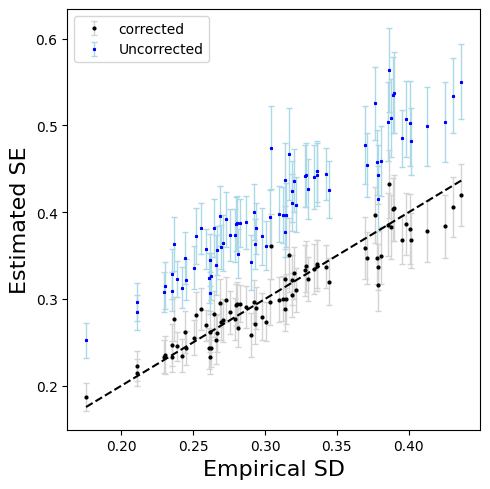

In [4]:

import numpy as np
import matplotlib.pyplot as plt

# 示例：x 是 empirical SD，长度为 n
# y 是每个 x 对应的 100 次预测 SE（shape: n x 100）
# 假设你已有以下变量：
# x: shape (n,)
# y: shape (n, 100)

# 计算 y 的均值和标准差（用于点和误差线）

y_mean = stdcrt.mean(axis=0)
index=(y_mean<1000)
y_mean=y_mean[index]
y_std = (stdcrt.std(axis=0))[index]

y_mean_uncorr = (std.mean(axis=0))[index]
y_std_uncorr = (std.std(axis=0))[index]
std1=std0[index]
# 画图
plt.figure(figsize=(5, 5))
plt.errorbar(std1, y_mean, yerr=y_std, fmt='o', color='black', ecolor='lightgray', elinewidth=1, capsize=2,markersize=2,label="corrected")

plt.errorbar(std1, y_mean_uncorr, yerr=y_std_uncorr,
             fmt='*', color='blue', ecolor='lightblue',
             elinewidth=1, capsize=2, markersize=2, label='Uncorrected')

# plt.scatter(std0, y_mean_uncorr, marker='*', color='blue', s=20, label='Uncorrected')

# # 手动画虚线误差线
# for xi, yi, err in zip(std0, y_mean_uncorr, y_std_uncorr):
#     plt.plot([xi, xi], [yi - err, yi + err], linestyle='--', color='lightblue', linewidth=1)
# # 画参考线 y = x
plt.plot([min(std1), max(std1)], [min(std1), max(std1)], 'k--')

plt.xlabel("Empirical SD",fontsize=16)
plt.ylabel("Estimated SE",fontsize=16)
# plt.title("ESM SE",fontsize=16)
# plt.axis('square')
plt.legend()
plt.tight_layout()
plt.savefig('part1sd.pdf')


In [5]:
y_mean = estimated_f.mean(axis=0)
y_std=estimated_f.std(axis=0)


ytrue_mean=true_f


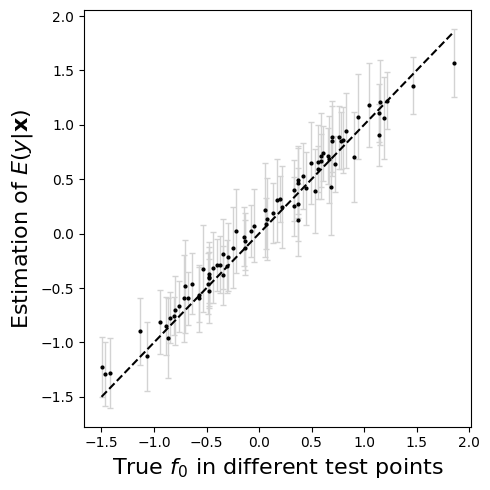

In [7]:

import numpy as np
import matplotlib.pyplot as plt

# 示例：x 是 empirical SD，长度为 n
# y 是每个 x 对应的 100 次预测 SE（shape: n x 100）
# 假设你已有以下变量：
# x: shape (n,)
# y: shape (n, 100)

# 计算 y 的均值和标准差（用于点和误差线）


# 画图
plt.figure(figsize=(5, 5))
plt.errorbar(ytrue_mean, y_mean, yerr=y_std, fmt='o', color='black', ecolor='lightgray', elinewidth=1, capsize=2,markersize=2)



# plt.scatter(std0, y_mean_uncorr, marker='*', color='blue', s=20, label='Uncorrected')

# # 手动画虚线误差线
# for xi, yi, err in zip(std0, y_mean_uncorr, y_std_uncorr):
#     plt.plot([xi, xi], [yi - err, yi + err], linestyle='--', color='lightblue', linewidth=1)
# # 画参考线 y = x
plt.plot([min(ytrue_mean), max(ytrue_mean)], [min(ytrue_mean), max(ytrue_mean)], 'k--')

plt.xlabel(r"True $f_0$ in different test points",fontsize=16)
plt.ylabel(r"Estimation of $E(y|\mathbf{x})$",fontsize=16)
# plt.title("ESM SE",fontsize=16)
# plt.axis('square')
# plt.legend()
plt.tight_layout()
plt.savefig('part1CI.pdf')
